# METAR Data Query using Siphon from a THREDDS server

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator,YearLocator, HourLocator,DayLocator,MonthLocator

from netCDF4 import num2date

from metpy.units import units
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta

import pandas as pd
import xarray as xr
import metpy
import metpy.calc as mpcalc
from PIL import Image
import pytz
from pytz import timezone

In [2]:
# Load in a collection of functions that process GEMPAK weather conditions and cloud cover data.
%run metargem_str.py

In [3]:
# Albany version is GEMPAK converted to netCDF.
# Two possibilities:  one is the one-year archive, updated once per day; the other is the most-recent week archive, updated in real time.
#metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'
metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecoded/catalog.xml?dataset=metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# Parse the xml and return a THREDDS Catalog Object.
catalog = TDSCatalog(metar_cat_url)

metar_dataset = catalog.datasets['Feature Collection']

In [4]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']

In [5]:
# We have the URL for our catalog's NetCDF Subset service, now create an object using the ncss client and pull
ncss = NCSS(ncss_url)

In [6]:
ncss.variables.remove('_isMissing')

In [7]:
# get current date and time

now = datetime.utcnow()
now = datetime(now.year, now.month, now.day, now.hour)
#day_1 = now - timedelta(hour=24)

# build the query
query = ncss.query()

In [8]:
# Select a location or list of locatons. 
#This can be either a single point (THREDDS will attempt to locate the nearest station) or an actual METAR site ID.

query.add_query_parameter(stns='ALB',subset='stns')

query.time(now)

#query.variables('all')
query.variables('PMSL', 'TMPC', 'DWPC', 'WNUM',
                'DRCT', 'SKNT', 'GUST', 'ALTI', 'CHC1', 'CHC2', 'CHC3')
query.accept('netcdf')

var=CHC1&var=SKNT&var=TMPC&var=WNUM&var=DWPC&var=PMSL&var=ALTI&var=DRCT&var=CHC2&var=CHC3&var=GUST&time=2024-05-12T16%3A00%3A00&stns=ALB&subset=stns&accept=netcdf

In [9]:
data = ncss.get_data(query)

In [10]:
data.variables

{'latitude': <class 'netCDF4._netCDF4.Variable'>
 float64 latitude(station)
     units: degrees_north
     long_name: station latitude
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'longitude': <class 'netCDF4._netCDF4.Variable'>
 float64 longitude(station)
     units: degrees_east
     long_name: station longitude
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'stationAltitude': <class 'netCDF4._netCDF4.Variable'>
 float64 stationAltitude(station)
     long_name: station altitude
     standard_name: surface_altitude
     positive: up
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'station_id': <class 'netCDF4._netCDF4.Variable'>
 |S1 station_id(station, station_id_strlen)
     long_name: station identifier
     cf_role: timeseries_id
 unlimited dimensions: 
 current shape = (1, 3)
 filling on, defa

In [11]:
station_id = data['station_id'][0].tobytes() #get station id
station_id = station_id.decode('ascii')
print(station_id)

ALB


In [12]:
time_var = data.variables['time'] #get the date & time of metar
#print (time_var)
time = num2date(time_var, time_var.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
time[0]

real_datetime(2024, 5, 12, 15, 40)

In [13]:
print(time[0])

2024-05-12 15:40:00


In [14]:
tmpc = data.variables['TMPC'][0] #define variables (using the first value)
dwpc = data.variables['DWPC'][0]
slp = data.variables['PMSL'][0]
wX = data.variables['WNUM'][0]
wdsp = data.variables['SKNT'][0]
wdir = data.variables['DRCT'][0]
gust = data.variables['GUST'][0]
pres = data.variables['ALTI'][0]

In [15]:
tmpc = tmpc.data * units('degC') #attch units where necessary
tmpf = tmpc.to('degF')
tmpC = round(tmpc, 0)
tmpF = round(tmpf, 0)

dwpc = dwpc.data * units('degC')
dwpf = dwpc.to('degF')
dwpC = round(dwpc, 0)
dwpF = round(dwpf, 0)

In [16]:
RH = mpcalc.relative_humidity_from_dewpoint(tmpc, dwpc).to('percent') #calculate RH
RH = round(RH, 0)

In [17]:
wdsp = wdsp.data * units('kts')
wdir_d = wdir.data * units('degrees')
wdsp

0.0 <Unit('knot')>

In [18]:
u, v = mpcalc.wind_components(wdsp, wdir_d)
u = (np.nan_to_num(u,True).astype(int))
v = (np.nan_to_num(v,True).astype(int))

In [19]:
gust = gust.data * units('kts')

In [20]:
wnum = (np.nan_to_num(data['WNUM'],True).astype(int))
wx = convert_wnum_str(wnum)

# Need to handle missing (NaN) and convert to proper code
chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
cloud_cover = calc_clouds(chc1, chc2, chc3)

In [21]:
cloud_cover = cloud_cover[0]

In [22]:
if cloud_cover == 0: #turn cloud cover number into a string
    cc = 'Clear'
elif cloud_cover == 1:
    cc = 'Mostly Clear'
elif cloud_cover == 3:
    cc = 'Partly Cloudy'
elif cloud_cover == 6:
    cc = 'Mostly Cloudy'
elif cloud_cover == 8:
    cc = 'Overcast'
elif cloud_cover == 9:
    cc =  'Cloud Cover Obstructed'
elif cloud_cover == -1:
    cc = 'Cloud Cover Missing'

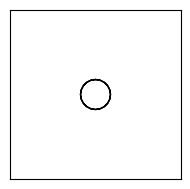

In [23]:
fig1, axs1 = plt.subplots(figsize=[2.2,2.2]) #plot wind barb
axs1.barbs(u, v, length=12, pivot='middle')
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('images/wind_barb.png')

In [24]:
im = Image.open('images/wind_barb.png') #open the saved plot

In [25]:
im = im.crop((30, 30, 195, 195)) #crop out border

In [26]:
rgba = im.convert("RGBA") #make background transparent
datas = rgba.getdata() 
  
newData = [] 
for item in datas: 
    if item[0] == 255 and item[1] == 255 and item[2] == 255:  # finding black colour by its RGB value 
        # storing a transparent value when we find a black colour 
        newData.append((255, 255, 255, 0)) 
    else: 
        newData.append(item)  # other colours remain unchanged 
  
rgba.putdata(newData) 
rgba.save("images/transparent_barb.png", "PNG")

In [27]:
def wdir_to_wdir_str(wind_dir): #get wdir str from wdr
    if 22.5 < wind_dir < 67.5:
        wind_dir_str = 'NE'
    elif 67.5 < wind_dir < 112.5:
        wind_dir_str = 'E'
    elif 112.5 < wind_dir < 157.5:
        wind_dir_str = 'SE'
    elif 157.5 < wind_dir < 202.5:
        wind_dir_str = 'S'
    elif 202.5 < wind_dir < 247.5:
        wind_dir_str = 'SW'
    elif 247.5 < wind_dir < 292.5:
        wind_dir_str = 'W'
    elif 292.5 < wind_dir < 337.5:
        wind_dir_str = 'NW'
    elif wind_dir > 337.5 or wind_dir < 22.5:
        wind_dir_str = 'N'
    else:
        wind_dir_str = 'VRB'
        
    return wind_dir_str

In [28]:
wdir_str = wdir_to_wdir_str(wdir)

In [29]:
slp = slp.__float__()

In [30]:
slp = slp * units('hPa')
slpHG = slp.to('inHg')

In [31]:
slp = round(slp, 1)
slpHG = round(slpHG, 2)

In [32]:
print('----------------')
print(f'Conditions in Albany as of {time[0]} UTC')
if wx == 'no_wx':
    print(cc)
else:
    print(wx)
print(f'Temperature: {tmpF} ({tmpC})')
print(f'Dewpoint: {dwpF} ({dwpC})')
print(f'Relative Humidity: {RH}')
if np.isnan(gust) == True:
    if wdsp == 0:
        print('Calm')
    else:
        print(f'Wind: {wdir_str} at {wdsp}')
else:
    print(f'Wind: {wdir_str} at {wdsp}, gusts to {gust}')
print(f'Sea-level Pressure: {slp} hPa')
print(f'Station Pressure {pres} inHG')
print('----------------')

----------------
Conditions in Albany as of 2024-05-12 15:40:00 UTC
Overcast
Temperature: 55.0 degree_Fahrenheit (13.0 degree_Celsius)
Dewpoint: 44.0 degree_Fahrenheit (7.0 degree_Celsius)
Relative Humidity: 66.0 percent
Calm
Sea-level Pressure: 1012.5 hectopascal hPa
Station Pressure nan inHG
----------------


In [33]:
tmpF = tmpF.magnitude
tmpC = tmpC.magnitude
dwpF = dwpF.magnitude
dwpC = dwpC.magnitude
RH = RH.magnitude
slp = slp.magnitude
slpHG = slpHG.magnitude
wdsp = wdsp.magnitude
gust = gust.magnitude

In [34]:
tmpF = int(tmpF)
tmpC = int(tmpC)
dwpF = int(dwpF)
dwpC = int(dwpC)
RH = int(RH)
windsp = int(wdsp)
if np.isnan(gust) == True:
    pass
else:
    gust = int(gust)

In [35]:
f = open('metar.txt', 'w')
if wx == 'no_wx':
    f.write(f'{cc}\n')
else:
    f.write(f'{wx}\n')
f.close()

f = open('metar.txt', 'a')
f.write(f'{tmpF}°F\n')
f.write(f'{tmpC}°C\n')
f.write(f'{dwpF}°F\n')
f.write(f'{dwpC}°C\n')
if np.isnan(gust) == True:
    if wdsp == 0:
        f.write('Calm\n')
    else:
        f.write(f'{wdir_str} at {windsp}kt\n')
else:
    f.write(f'{wdir_str} at {windsp}kt, G{gust}kt\n')
f.write(f'{RH}%\n')
f.write(f'{slp}mb\n')
f.write(f'{slpHG}"\n')
f.close()

In [36]:
cc

'Overcast'

In [37]:
imgWx = get_wx_img(wx, cloud_cover, wdsp)
imgWx

'NWS_images/cloud_cover/overcast/ovc.png'

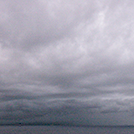

In [38]:
current_wx = Image.open(imgWx)
current_wx

In [39]:
if current_wx.size[0] != 86:
    current_wx = current_wx.resize((86, 86))
else:
    pass

In [40]:
current_wx.save('images/current_wx.png')